# Tarea 3

## Estudiante: Andrés Calderón Guardia

Usamos un dataset pequeñito de analisis de sentimiento en tweets. Cada tweet viene con una etiqueta entre `positive`, `negative` y `neutral`.

**Vamos a ver como usar:**
* Utilizar una representacion de word embedding ya entrenada
* Utilizar estas representaciones con MLP y un RNN
* Comparar con un RNN que va apprende su capa de embeddings
* Utilizar un modelo pre-entrenado contextual como BERT

## Se puede utilizar LLM para ayudarse!
Mirar a [un ejemplo](https://chatgpt.com/share/d534833e-bd2c-40c1-81eb-34818b195cac) de como pedir las respuestas a un LLM. Mejor si entenden lo que hagan.

#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  

### Before Starting! Some tips on GPU and Google Colab

You will likely to run this code on Google Colab in order to use GPU ressources. If not, the code will take 60 times more to run!!  

#### Stop disconnection

Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser:

```java
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

See more [here](https://www.reddit.com/r/StableDiffusion/comments/xhhlp0/automatic1111_on_colab_how_to_keep_it_running/).

#### Other account

If you run out of available ressources, what you can do is changing of the account you are using in colab. You can create another gmail and switch to it, this should give you more GPU ressources.

Have fun!

In [1]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts.zip
! unzip Texts.zip

--2024-10-25 22:42:40--  https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts.zip
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143512 (140K) [application/zip]
Saving to: ‘Texts.zip’

Texts.zip           100%[===================>] 140.15K   350KB/s    in 0.4s    

2024-10-25 22:42:41 (350 KB/s) - ‘Texts.zip’ saved [143512/143512]

Archive:  Texts.zip
  inflating: MModal_Sentiment_dev.tsv  
  inflating: MModal_Sentiment_test.tsv  
  inflating: MModal_Sentiment_train.tsv  


In [2]:
import pandas as pd

def read_data(fn):
    df = pd.read_csv(fn, sep='\t')[['tweet', 'label']]
    X = df.tweet
    y = df.label
    return X, y

split='train'
X_train, y_train = read_data('MModal_Sentiment_%s.tsv'%split)
split='dev'
X_dev, y_dev = read_data('MModal_Sentiment_%s.tsv'%split)
split='test'
X_test, y_test = read_data('MModal_Sentiment_%s.tsv'%split)

## Word2vec

Construir una funcion que va a representar un texto. Utilizamos `'glove-twitter-25'` porque es el mas pequeño. Pueden probar con otros modelos mas grandes!

In [3]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
wv_string = 'glove-twitter-25'
wv = gensim.downloader.load(wv_string)

[==================================================] 100.0% 104.8/104.8MB downloaded


Visualizamos el vector de la palabra *computer*, y cuales son las palabras de los vectores los mas similares en el espacio utilizando la distancia cosinus

In [5]:
wv['computer'], wv.most_similar('computer')

(array([ 0.64005 , -0.019514,  0.70148 , -0.66123 ,  1.1723  , -0.58859 ,
         0.25917 , -0.81541 ,  1.1708  ,  1.1413  , -0.15405 , -0.11369 ,
        -3.8414  , -0.87233 ,  0.47489 ,  1.1541  ,  0.97678 ,  1.1107  ,
        -0.14572 , -0.52013 , -0.52234 , -0.92349 ,  0.34651 ,  0.061939,
        -0.57375 ], dtype=float32),
 [('camera', 0.907833456993103),
  ('cell', 0.891890287399292),
  ('server', 0.874466598033905),
  ('device', 0.8693525195121765),
  ('wifi', 0.863125741481781),
  ('screen', 0.8621907234191895),
  ('app', 0.8615543246269226),
  ('case', 0.8587921857833862),
  ('remote', 0.8583616018295288),
  ('file', 0.8575270771980286)])

### Transform the docs into sequences of embeddings

We take the word-vectors of each of the words in the sentence, so for each sentence we get a sequence of vectors

In [6]:
vocabulary = wv.index_to_key

def from_wd_to_vec(documents):
    documents_wvs = [
        [wv[word] for word in document.lower().split() if word in vocabulary]
        for document in documents
    ]
    return documents_wvs

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# TODO: Create the representations
documents_train_wvs = from_wd_to_vec(X_train)
documents_dev_wvs = from_wd_to_vec(X_dev)
documents_test_wvs = from_wd_to_vec(X_test)

#### Visualizacion

Visualiza los vectores en 2D con sus labeles. Usa T-SNE o UMAP

* Para tener un unico vector representando una frase, se puede aggergar los vectores de cada palabra tomando en promedio de los vectores

Por ejemplo utilizando:
```python
documents_wv = [np.mean(list_wv_sent, axis=0) for list_wv_sent in documents_wvs]
```

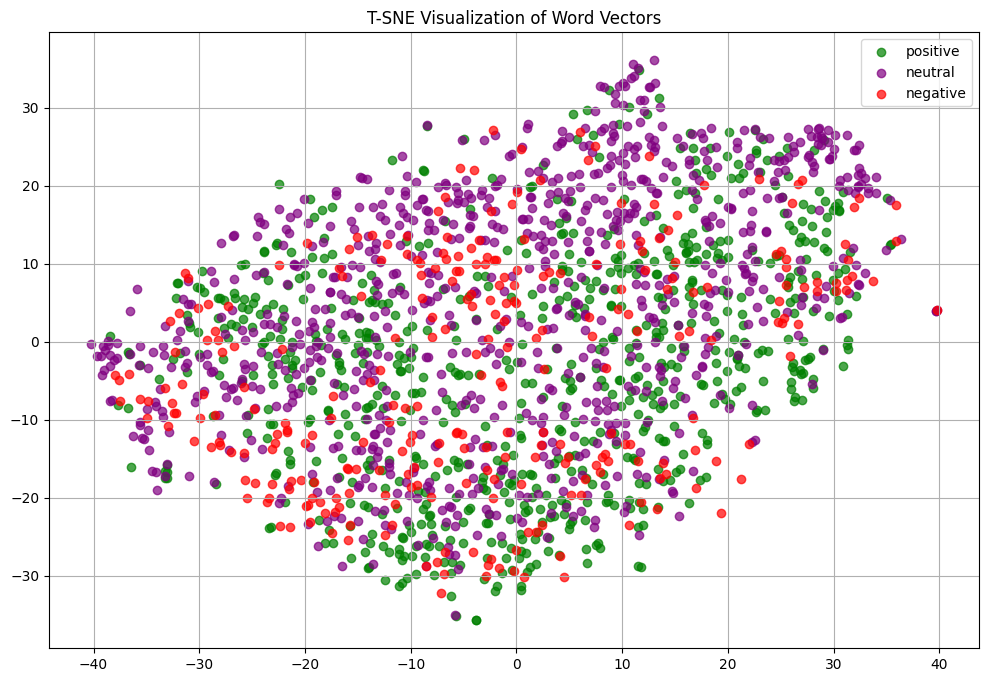

In [9]:
# TODO: Visualization

# Create aggregated numpy array
X_train_wvs = np.array([np.mean(list_wv_sent, axis=0) for list_wv_sent in documents_train_wvs])
X_dev_wvs = np.array([np.mean(list_wv_sent, axis=0) for list_wv_sent in documents_dev_wvs])
X_test_wvs = np.array([np.mean(list_wv_sent, axis=0) for list_wv_sent in documents_test_wvs])

# Applying T-SNE to reduce the dimensionality of word vectors
X_train_tsne = TSNE(n_components=2, metric="cosine").fit_transform(X_train_wvs)

# Visualize the T-SNE output
unique_labels = y_train.unique()
colors = ["green", "purple", "red"]
plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    indices = np.where(y_train == label)
    plt.scatter(X_train_tsne[indices, 0], X_train_tsne[indices, 1],
                c=[colors[i]], label=label, alpha=0.7)

plt.title("T-SNE Visualization of Word Vectors")
plt.grid(True)
plt.legend(loc="best")
plt.show()

## Modelizacion

**Metricas**: Para este tarea de clasificacion pueden utilizar el score F-1 para estimar las performancias de los modelos  

### Multi-Layer Perceptron

El MLP solo toma un vector en entrada, no una secuencia de vectores, por eso tenemos que agregar los vectores de las palabras de una sentencia en uno.  

* Aggreg the word vectors of each doc to get one vector per doc
* Learn a MLP

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [11]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_wvs, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_dev_tensor = torch.tensor(X_dev_wvs, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_wvs, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [13]:
# Define model parameters
input_size = X_train_wvs.shape[1]
hidden_size = 64
output_size = len(y_train.unique())

# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training the MLP
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # Update weights

        running_loss += loss.item()

    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Function to evaluate using F1-score
def evaluate(loader, model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1-score
    f1 = f1_score(all_labels, all_preds, average='macro')
    return f1

# Evaluate on the validation (dev) set
dev_f1_score = evaluate(dev_loader, model)
print(f'Validation F1-Score: {dev_f1_score:.4f}')

# Evaluate on the test set
test_f1_score = evaluate(test_loader, model)
print(f'Test F1-Score: {test_f1_score:.4f}')

Validation F1-Score: 0.5729
Test F1-Score: 0.5504


### RNN-LSTM

Use the sequences of wordvectors using a Recurrent Neural Network

In [14]:
# Pad sequences to the same length
def pad_sequences(sequences, pad_value=0.0):
    # Convert each list of word vectors (documents) to tensors
    sequence_tensors = [torch.tensor(np.array(seq), dtype=torch.float32) for seq in sequences]
    # Pad the sequences to make them the same length
    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequence_tensors, batch_first=True, padding_value=pad_value)
    return padded_sequences

In [13]:
# Custom dataset class to handle sequences
class SequenceDataset(Dataset):
    def __init__(self, documents_wvs, labels):
        self.documents_wvs = pad_sequences(documents_wvs)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.documents_wvs[idx], self.labels[idx]

In [15]:
# Prepare datasets
train_dataset = SequenceDataset(documents_train_wvs, y_train_encoded)
dev_dataset = SequenceDataset(documents_dev_wvs, y_dev_encoded)
test_dataset = SequenceDataset(documents_test_wvs, y_test_encoded)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=bidirectional)
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction, output_size)

    def forward(self, x):
        # Initialize hidden and cell state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Use the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [19]:
# Model parameters
input_size = 25
hidden_size = 64
output_size = len(label_encoder.classes_)
num_layers = 2
bidirectional = True

# Instantiate the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers, bidirectional)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate on dev and test sets
dev_f1_score = evaluate(dev_loader, model)
print(f'Validation F1-Score: {dev_f1_score:.4f}')

test_f1_score = evaluate(test_loader, model)
print(f'Test F1-Score: {test_f1_score:.4f}')

Validation F1-Score: 0.5605
Test F1-Score: 0.5769


### Preguntas

* Cuál es la ventaja de la modelización con RNN sobre MLP al usar una agregación de word embeddings?
* Cuál es el beneficio de inicializar el RNN con los word embeddings de Word2Vec?
* Como se comparan los entrenamientos de los diferentes modelos?
* Como se comparan los resultados de los diferentes modelos?
* Que podemos ver con modelos de embedding mas grandes (complejos)?

### Respuestas

- RNN es un modelo tal que aprende del contexto de las palabras, de forma que es poco propenso a realizar overfitting sobre los datos, considerando que siempre intenta reconocer un contexto en estos, a diferencia del MLP el cual su método de aprendizaje es analizar los datos de forma independiente, de modo que no genera relaciones entre las palabras.
- Word2Vec mejora el entrenamiento de este modelo dado que utilizando sus word embeddings captura mejor las propiedades semánticas del texto, de forma que el modelo es capaz de obtener fácilmente la similitud semántica entre palabras.
- RNN resulta ser más lento dado que es un modelo más complejo en comparación a MLP, considerando que utiliza estas relaciones entre palabras según el contexto como parte de su entrenamiento, en contraste con MLP que toma los datos de forma independiente.
- Considerando que RNN es un modelo que se adapta mejor al análisis del texto sus resultados terminan siendo mejores que los de MLP, lo que se respalda con esta experimentación ya que se logró obtener un mejor F1-score con RNN, por alrededor de un 2% al realizar 100 épocas en cada modelo.
- Estos modelos de embedding complejos (algunos ejemplos son GPT, BERT, RoBERTa, entre otros) permiten una comprensión más profunda y detallada del lenguaje, aunque una desventaja que poseen es que son propensos a sufrir de overfitting de los datos de entrenamiento utilizados si es que estos no se manejan adecuadamente dada la alta capacidad de ajuste que estos poseen.


## BERT

Use a pre-trained BERT from the HuggingFace library and fine-tune it on the dataset.

* For the data, you can use the classes `Dataset` and `DataLoader` from `torch.utils.data`
* For the modelization:
  * You can use the classes `BertTokenizer` and `BertForSequenceClassification` from the `transformers` library
  * Load the weights of the models already pre-trained, with the associated tokenizer!
  * You can use a [classical bert](https://huggingface.co/bert-base-uncased) `'bert-base-uncased'`  
  * You can also use another model from huggingface, like [a smaller model](https://huggingface.co/distilbert-base-uncased) such as `distilbert-base-uncased` (it is an example)
* For the fine-tuning (optimization):
    * Make the loop in pytorch, **do not use** the class `Trainer` from the `transformers` library
    * You can use classical loss functions like cross-entropy and the optimizer you want, `Adam` or `AdamW` for example.
    * Reports the loss and accuracy curves on the train and validation
    * Stop the training regarding the performances obtained on the validation set
    * Use a small learning rate so you can see the loss going down on the different curves  

In [16]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score

In [40]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(y_train)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [41]:
train_dataset = TextDataset(X_train, y_train_encoded, tokenizer)
dev_dataset = TextDataset(X_dev, y_dev_encoded, tokenizer)
test_dataset = TextDataset(X_test, y_test_encoded, tokenizer)

In [42]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
train_losses = []
dev_losses = []
best_dev_f1 = 0.0

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    all_preds = []
    all_labels = []
    running_dev_loss = 0.0

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            running_dev_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_dev_loss = running_dev_loss / len(dev_loader)
    dev_losses.append(avg_dev_loss)

    # Calculate accuracy and F1-score
    dev_accuracy = accuracy_score(all_labels, all_preds)
    dev_f1_score = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Dev Loss: {avg_dev_loss:.4f}, Dev F1-Score: {dev_f1_score:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    # Save the best model based on F1-Score
    if dev_f1_score > best_dev_f1:
        best_dev_f1 = dev_f1_score
        torch.save(model.state_dict(), 'best_model.bin')
    else:
        print("Early stop")
        break

Epoch [1/10], Train Loss: 0.9705, Dev Loss: 0.8818, Dev F1-Score: 0.6035, Dev Accuracy: 0.6096
Epoch [2/10], Train Loss: 0.7556, Dev Loss: 0.7556, Dev F1-Score: 0.6595, Dev Accuracy: 0.6672
Epoch [3/10], Train Loss: 0.5415, Dev Loss: 0.7208, Dev F1-Score: 0.6860, Dev Accuracy: 0.6858
Epoch [4/10], Train Loss: 0.3749, Dev Loss: 0.8079, Dev F1-Score: 0.6949, Dev Accuracy: 0.6936
Epoch [5/10], Train Loss: 0.2356, Dev Loss: 0.9563, Dev F1-Score: 0.6598, Dev Accuracy: 0.6610
Early stop


Test Loss: 0.7916
Test F1-Score: 0.6834, Test Accuracy: 0.6838


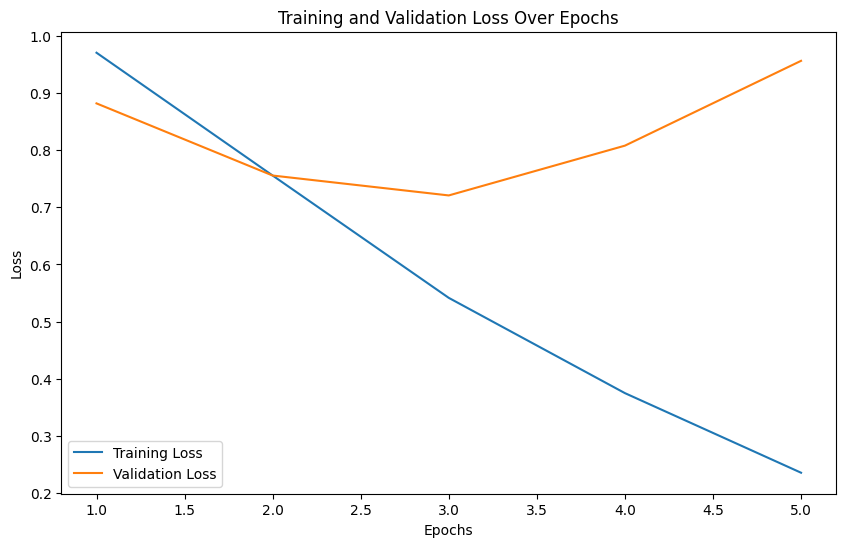

In [46]:
model.load_state_dict(torch.load('best_model.bin', weights_only=True))
model.eval()

all_preds = []
all_labels = []
running_test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        running_test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy and F1-score
test_accuracy = accuracy_score(all_labels, all_preds)
test_f1_score = f1_score(all_labels, all_preds, average='weighted')
test_loss = running_test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1-Score: {test_f1_score:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot the loss curves
epochs = range(1, 6)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## [CLS]

In [23]:
def extract_cls_embeddings(dataloader):
    model.eval()
    cls_embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].cpu().numpy()

            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]
            cls_tokens = hidden_states[:, 0, :]
            cls_embeddings.append(cls_tokens.cpu().numpy())
            labels.extend(labels_batch)

    cls_embeddings = np.concatenate(cls_embeddings, axis=0)
    return cls_embeddings, np.array(labels)

In [47]:
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(10, 6))
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=f"Class {label}", alpha=0.7)

    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(["positive", "neutral", "negative"])
    plt.show()

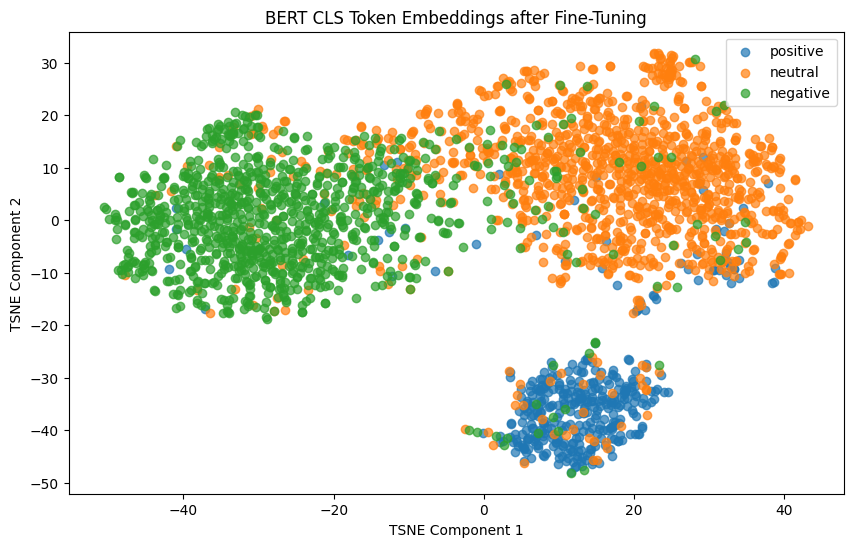

In [48]:
# Extract CLS token embeddings for the training set
train_cls_embeddings, train_labels = extract_cls_embeddings(train_loader)
dev_cls_embeddings, dev_labels = extract_cls_embeddings(dev_loader)
test_cls_embeddings, test_labels = extract_cls_embeddings(test_loader)

# Combine train and validation embeddings for visualization
all_embeddings = np.concatenate((train_cls_embeddings, dev_cls_embeddings), axis=0)
all_labels = np.concatenate((train_labels, dev_labels), axis=0)

# Apply T-SNE for dimensionality reduction
embeddings_2d = TSNE(n_components=2).fit_transform(all_embeddings)

# Visualize train + dev embeddings
plot_embeddings(embeddings_2d, all_labels, "BERT CLS Token Embeddings after Fine-Tuning")

### Preguntas

* Haz una hipótesis sobre por qué los resultados de BERT son mejores que los de otros modelos.
* Cuál es la principal limitación de Word2Vec en comparación con BERT a nivel lingüístico al representar palabras? Propón un ejemplo.
* Visualiza los vectores del token `[CLS]` de BERT después del fine-tuning. Qué diferencias notas en comparación con antes?
* Qué sucede si utilizas un modelo diferente, como RoBERTa?

#### Respuestas

- BERT se destaca sobre los otros modelos dada su arquitectura y métodos que utiliza. En particular, la combinación de representaciones contextualizadas, pre-entrenamiento bidireccional y capacidad para fine-tuning son algunas de las características que le permiten a BERT capturar las complejidades del lenguaje de manera más precisa, resultando en un rendimiento generalmente superior en comparación con MLP y RNN, a costa de un tiempo de entrenamiento mucho mayor.
- La principal limitación de Word2Vec es que genera representaciones estáticas para cada palabra, sin tener en cuenta el contexto en el que aparece.

    Para entenderlo mejor consideremos la palabra "helado", la cual con Word2Vec se limita a tener un único vector para representar su significado en cualquier caso. En contraste, con BERT se generarían varios vectores para interpretar sus variados significados según el contexto, como por ejemplo, al mencionar "este helado está muy bueno" y "hoy dia está muy helado", este sería capaz de diferenciar el significado de "helado" según el contexto de ambas oraciones.
- Se evidencia una agrupación de los datos bastante más evidente en comparación al momento previo de hacer el fine-tuning, ya que antes los datos estaban dispersos en el espacio de forma similar para todas las categorías, aunque igualmente existe un pequeño solapamiento entre las clases.
-

In [27]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [35]:
# Load the RoBERTa tokenizer and model
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(y_train)))

train_dataset = TextDataset(X_train, y_train_encoded, tokenizer)
dev_dataset = TextDataset(X_dev, y_dev_encoded, tokenizer)
test_dataset = TextDataset(X_test, y_test_encoded, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

batch_size = 16
num_epochs = 10
train_losses = []
dev_losses = []
best_dev_f1 = 0.0

optimizer = AdamW(model.parameters(), lr=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    all_preds = []
    all_labels = []
    running_dev_loss = 0.0

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            running_dev_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_dev_loss = running_dev_loss / len(dev_loader)
    dev_losses.append(avg_dev_loss)

    # Calculate accuracy and F1-score
    dev_accuracy = accuracy_score(all_labels, all_preds)
    dev_f1_score = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Dev Loss: {avg_dev_loss:.4f}, Dev F1-Score: {dev_f1_score:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    # Save the best model based on F1-Score
    if dev_f1_score > best_dev_f1:
        best_dev_f1 = dev_f1_score
        torch.save(model.state_dict(), 'best_roberta_model.bin')
    else:
        print("Early stop")
        break

# Evaluate on the test set
model.load_state_dict(torch.load('best_roberta_model.bin', weights_only=True))
model.eval()

all_preds = []
all_labels = []
running_test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        running_test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
test_f1_score = f1_score(all_labels, all_preds, average='weighted')
test_loss = running_test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1-Score: {test_f1_score:.4f}, Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depreca

Epoch [1/10], Train Loss: 0.9893, Dev Loss: 0.7186, Dev F1-Score: 0.6809, Dev Accuracy: 0.6812
Epoch [2/10], Train Loss: 0.6851, Dev Loss: 0.6702, Dev F1-Score: 0.7076, Dev Accuracy: 0.7076
Epoch [3/10], Train Loss: 0.5599, Dev Loss: 0.6742, Dev F1-Score: 0.7099, Dev Accuracy: 0.7107
Epoch [4/10], Train Loss: 0.4213, Dev Loss: 0.6867, Dev F1-Score: 0.7230, Dev Accuracy: 0.7216
Epoch [5/10], Train Loss: 0.3063, Dev Loss: 0.7905, Dev F1-Score: 0.7049, Dev Accuracy: 0.7014
Early stop
Test Loss: 0.6754
Test F1-Score: 0.7180, Test Accuracy: 0.7169


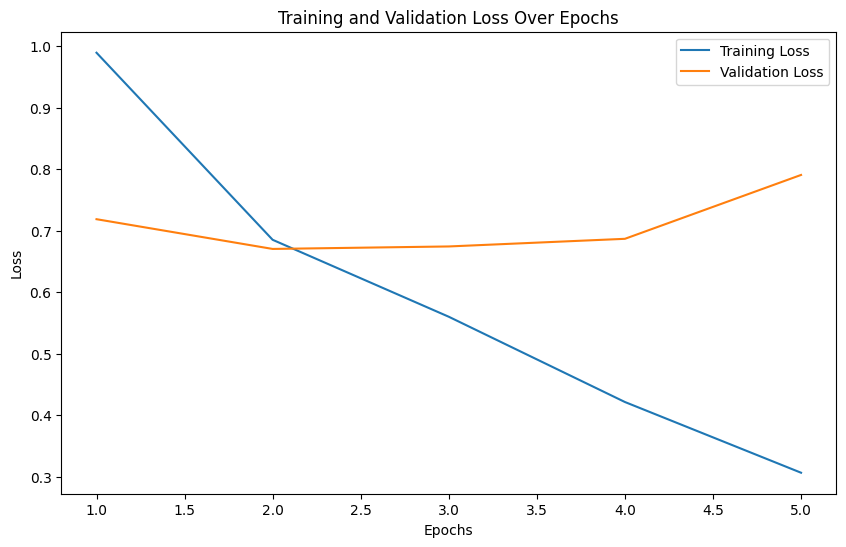

In [38]:
# Plot the training and validation loss curves
epochs = range(1, 6)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

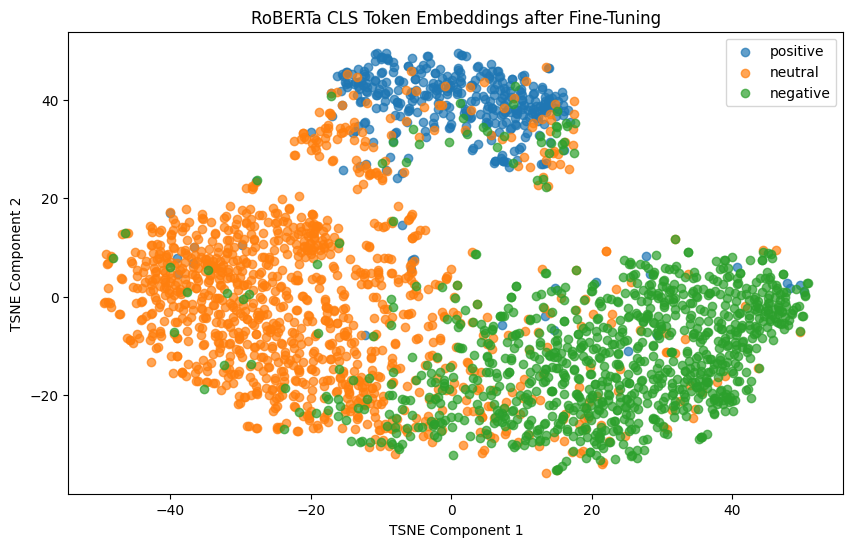

In [39]:
# Extract CLS token embeddings for train and validation
train_cls_embeddings, train_labels = extract_cls_embeddings(train_loader)
dev_cls_embeddings, dev_labels = extract_cls_embeddings(dev_loader)

# Combine train and validation embeddings
all_embeddings = np.concatenate((train_cls_embeddings, dev_cls_embeddings), axis=0)
all_labels = np.concatenate((train_labels, dev_labels), axis=0)

# Apply T-SNE for dimensionality reduction
embeddings_2d = TSNE(n_components=2).fit_transform(all_embeddings)

plot_embeddings(embeddings_2d, all_labels, "RoBERTa CLS Token Embeddings after Fine-Tuning")

Finalmente, es posible concluir que el modelo RoBERTa obtuvo un mejor F1-score en comparación a BERT, considerando que ambos llegaron a realizar la misma cantidad de épocas antes de terminar el entrenamiento por cortocircuito. Es posible evidenciar que la forma de los grupos generados es ligeramente distinta a la de BERT, además de poseer a primera vista un solapamiento ligeramente mayor, indicando la posibilidad de que estas clases pueden estar más relacionadas de lo que parecen.